In [1]:
import pandas as pd
import pickle

In [2]:
models = [
    "bloom_label_v1.xlsx",
    "bloomz_label_v3.xlsx",
    "gpt_label_v7.xlsx"
]

In [3]:
preds = {
    k: pd.read_excel(k) for k in models
}
o = pickle.load(open("respuesta_youchat_v8.pickle", "rb"))
chat_prediction = pd.DataFrame(o, columns="Q_id id you".split())
chat_prediction["you-label"] = chat_prediction["you"].apply(lambda x: x.replace("Esta respuesta es", "").split()[0] if "Esta respuesta es" in x else x.replace("La respuesta es", "").split()[0] if "La respuesta es" in x else x)
chat_prediction["you-label"] = chat_prediction["you"].apply(lambda x: 1 if "incoherente" in x else 0)

compare = preds["gpt_label_v7.xlsx"].set_index("id")
compare["you"] = chat_prediction.set_index("id").loc[compare.index]["you"]
compare["you-label"] = chat_prediction.set_index("id").loc[compare.index]["you-label"]
compare = compare.drop(columns="gpt-label  gpt  Unnamed: 0".split("  "))
preds["youchat.xlsx"] = compare.loc[preds["gpt_label_v7.xlsx"].set_index("id").index]
indexs = preds["youchat.xlsx"].index
for k in preds.keys(): 
    preds[k]["eq"] = preds[k].apply(lambda x: {(1, 1): 1, (0, 0): 5, (1, 0): 25, (0, 1): 25*4}[(x.iloc[-1], x.iloc[-3])], axis=1)
    if k != "youchat.xlsx":
        preds[k] = preds[k].set_index("id").loc[indexs]

In [4]:
comp = []
for k in preds.keys():
    comp += [list(preds[k]["eq"].values)]

In [5]:
import numpy as np

In [6]:
df_comp = pd.DataFrame(comp, columns=preds[k].index).T
df_comp["sum"] = df_comp.sum(axis=1)
df_comp["type"] = df_comp.apply(lambda x: str(x.values[:-1]), axis=1)
df_comp["ord"] = df_comp.apply(lambda x: np.argmax(df_comp["type"].unique() == x["type"]), axis=1)
df_comp = df_comp.sort_values(["sum", "ord"], ignore_index=False, inplace=False)
df_comp

,0,1,2,3,sum,type,ord
id,,,,,,,
88565,1,1,1,1,4,[1 1 1 1],3
51688,1,1,1,1,4,[1 1 1 1],3
73857,1,1,1,1,4,[1 1 1 1],3
92561,1,1,1,1,4,[1 1 1 1],3
49317,1,1,1,1,4,[1 1 1 1],3
...,...,...,...,...,...,...,...
83459,1,100,1,100,202,[ 1 100 1 100],19
68572,100,100,1,1,202,[100 100 1 1],21
48858,100,1,100,100,301,[100 1 100 100],11


In [7]:
from matplotlib import pyplot as plt

In [8]:
df_comp[[0, 1, 2, 3, "sum"]].values[600]

array([ 25,  25,  25,  25, 100], dtype=int64)

In [797]:
df_comp

,0,1,2,3,sum,type,ord
id,,,,,,,
88565,1,1,1,1,4,[1 1 1 1],3
51688,1,1,1,1,4,[1 1 1 1],3
73857,1,1,1,1,4,[1 1 1 1],3
92561,1,1,1,1,4,[1 1 1 1],3
49317,1,1,1,1,4,[1 1 1 1],3
...,...,...,...,...,...,...,...
83459,1,100,1,100,202,[ 1 100 1 100],19
68572,100,100,1,1,202,[100 100 1 1],21
48858,100,1,100,100,301,[100 1 100 100],11


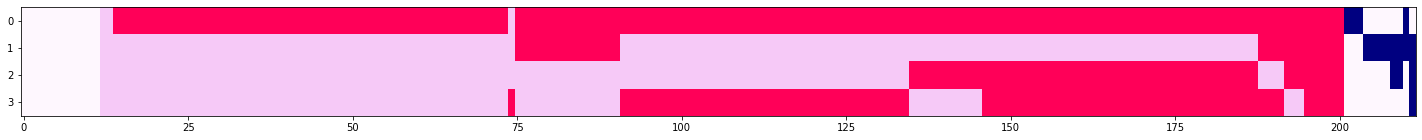

In [806]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(df_comp.loc[X_co.index][[0, 1, 2, 3]].T, interpolation='nearest', aspect='auto', cmap="gist_ncar_r")

0: bloom, 
1: bloomz, 
2: gpt-3, 
3: youchat

rojo: TN
azul: TP
celeste: FP
naranjo: FN

In [809]:
X_raw = preds['gpt_label_v7.xlsx'].loc[df_comp.index]["gpt-label label Q_id Q A".split()]
X_co = X_raw[X_raw["Q"].apply(lambda x: "correcto" in x)]
X_co

,gpt-label,label,Q_id,Q,A
id,,,,,
92561,1,1,4959,Agustín desea guardar unos dados de 1 cm cúbic...,","
92664,1,1,4965,Agustín desea guardar unos dados de 1 cm cúbic...,","
90671,1,1,4844,Carolina debe leer a lo más 15 páginas de un l...,y\n ...
87338,1,1,4666,El agricultor Braulio distribuye su cosecha de...,nose
75650,1,1,4049,Amanda compró 2 chocolates a $135 cada uno y u...,no se
...,...,...,...,...,...
68213,1,1,3707,"Pedro puso 70 vasos plásticos en una bandeja,...",alludeme tio porfabor tio pablo
82873,0,1,4420,Alonso comió 2/7 de un chocolate. Éste dice qu...,7/5
68164,0,1,3701,Alejandra ha trabajado en conectaideas 3 días ...,Tía la respuesta es 363☺😊☺😊☺😊


In [834]:
X_co[X_co["gpt-label"] != X_co["label"]]["Q_id"].value_counts()

4035    4
4026    3
4054    3
4420    2
3109    2
3118    2
4837    2
3995    2
5044    2
4844    2
4403    2
4810    2
3742    1
4495    1
4397    1
4496    1
4551    1
3899    1
5087    1
3730    1
3282    1
4959    1
4487    1
3941    1
4828    1
3460    1
4818    1
4649    1
4531    1
4839    1
4787    1
4790    1
3982    1
4591    1
4926    1
4509    1
3943    1
4001    1
4049    1
4955    1
4807    1
4056    1
4133    1
3917    1
3478    1
3409    1
4690    1
4431    1
3701    1
Name: Q_id, dtype: int64

In [892]:
X_co[X_co["Q_id"] == 4035].iloc[-1]["A"]

'esta mal por es 520'

In [812]:
descr = {
    4959: 0 # len<2 entonces 1
}

In [253]:
seg = pd.read_excel("seg_TM_test_v1.xlsx", index_col=0).set_index("id")
seg

,Q_id,Q,A,label,TM
id,,,,,
85815,4581,¿Qué aprendiste de la actividad del viernes?,ha ver las cajas porque las cajas chicas eran ...,0,haber las cajas porque las cajas chicas eran l...
64812,3535,¿Cómo creen ustedes que se reproducen las célu...,El proceso de división de una célula en dos cé...,0,el proceso de division de una celula en dos ce...
84148,4491,¿ Qué frase para mejorar le darías tú a un am...,debes practicar los ejerccios,0,debes practicar los ejerccios
88565,4734,¿Qué aprendiste en la actividad del día viernes?,Nose porque no fui. A donde fueron ustedes😛😛😛😛😜,1,no se porque no fui . a donde fueron ustedes
51688,2944,Diego compró 2 sopaipillas a $120 cada una. Pa...,las sopaipillas,1,las sopaipillas
...,...,...,...,...,...
54685,3109,Lorena dice que al multiplicar 3x0 le da como...,estamal poreque es 0,0,esta mal porqué es 0
87324,4665,Alicia comió 2/9 de un chocolate. Ella dice qu...,esta mal Alicia por que la cantidad es 7/8 de...,0,esta mal alicia por que la cantidad es 7 / 8 d...
73798,3946,El cuarto básico visitará el zoológico. Si son...,nose\n,1,no se


In [254]:
import Levenshtein as lv

In [265]:
seg["lev"] = seg.apply(lambda x: lv.distance(x["A"], x["TM"])/lv.distance(x["A"], ""), axis=1)

In [10]:
preds.keys()

dict_keys(['bloom_label_v1.xlsx', 'bloomz_label_v3.xlsx', 'gpt_label_v7.xlsx', 'youchat.xlsx'])

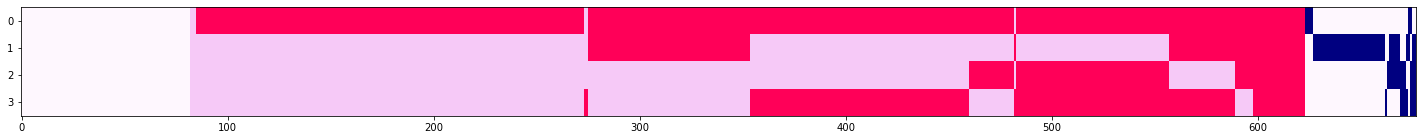

In [901]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(df_comp[[0, 1, 2, 3]].T, interpolation='nearest', aspect='auto', cmap="gist_ncar_r")

In [965]:
preds['gpt_label_v7.xlsx'].loc[df_comp.index]["gpt-label label Q A".split()].values[499]

array([1, 0,
       'Andrea y Pedro fueron a comprar al supermercado comida para sus mascotas, Andrea salio a las 14:30 y regreso a su casa a las 15:15 y Predro salio a las 13:45 y regreso a la misma hora que Andrea. ¿Cuanto demoro Andrea en hacer las compras?¿Cuanto demoro Pedro en hacer las compras? Explica con tus palabras como llegaste al resultado',
       'Pedro.  Se. Demoro.  90.  Minutos.  Y.  Andrea.  45. Minutos.   Lo.  Ise.  Con.  Suma'],
      dtype=object)

In [978]:
best_beto = pickle.load(open("D:/Untitled Folder/df_2017_pred_beto_mt.pickle", "rb"))
best_beto = best_beto["label_beto:mt respuesta_id".split()].set_index("respuesta_id")
best_beto

,label_beto:mt
respuesta_id,
51894.0,1
51918.0,1
51909.0,0
51897.0,0
51892.0,0
...,...
96198.0,0
96195.0,0
96196.0,0


In [984]:
o = preds['gpt_label_v7.xlsx'].loc[df_comp.index].copy()
o["beto-label"] = best_beto.loc[o.index]
o.to_excel("D:/github/coherence-prediction/beto_label_v7_comp_v2.xlsx")

In [13]:
!pip install -U scikit-learn

In [15]:
!pip install --upgrade scikit-learn

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import plot_confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

In [20]:
from unidecode import unidecode

In [539]:
preds.keys()

dict_keys(['bloom_label_v1.xlsx', 'bloomz_label_v3.xlsx', 'gpt_label_v7.xlsx', 'youchat.xlsx'])

In [772]:
X_raw = preds['gpt_label_v7.xlsx'].loc[df_comp.index]["gpt-label label Q A".split()]
X_raw["eq"] = ((df_comp[2] == 25)).apply(int)
X_data = X_raw["Q A".split()]
X_data["Q"] = X_data["Q"].apply(lambda x: unidecode(str(x)))
X_data["A"] = X_data["A"].apply(lambda x: unidecode(str(x).replace("\n", "")))
y_data = X_raw["eq"]

<ipython-input-772-fc293a8289e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data["Q"] = X_data["Q"].apply(lambda x: unidecode(str(x)))
<ipython-input-772-fc293a8289e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data["A"] = X_data["A"].apply(lambda x: unidecode(str(x).replace("\n", "")))


In [773]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')

In [774]:
class LemmaTokenizer(object):
    def __call__(self, text):
        return [t for t in word_tokenize(text) if t not in string.punctuation and t.isalpha() and t not in 
                ["agolo", "recibio", "que", "y", "le", "con", "al", "manzanas", "a", "de", "por", "sus", "mas", "en", "moneda"]]

In [775]:
np.array(X_a.todense()).shape

(677, 1216)

In [776]:
q_vect = CountVectorizer(min_df=5, lowercase=True, ngram_range=(1, 1), tokenizer=LemmaTokenizer())
a_vect = CountVectorizer(lowercase=True, ngram_range=(1, 1), tokenizer=LemmaTokenizer())    

X_q = q_vect.fit_transform(X_data["Q"])
X_a = a_vect.fit_transform(X_data["A"])
lenA = np.array([[len(a)] for a in X_data["A"]]).reshape(-1,1)
lenQ = np.array([[len(a)] for a in X_data["Q"]]).reshape(-1,1)

X_bow = np.hstack([np.array(X_q.todense()), np.array(X_a.todense()), np.array(seg[["lev"]].values), lenA, lenQ, np.array(ex0.reset_index()[["Q"]].values), np.array(ex1.reset_index()[["Q"]].values)])

C:\Users\felip\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [777]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_data, stratify=y_data, test_size=.1, random_state=42)

In [778]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8587848932676518, 0.8088235294117647)

In [779]:
feature_names = [f"Q[{x}]" for x in list(q_vect.get_feature_names_out())] + [f"A[{x}]" for x in list(a_vect.get_feature_names_out())] + ["lev", "lenA", "lenQ", "ex0", "ex1"]

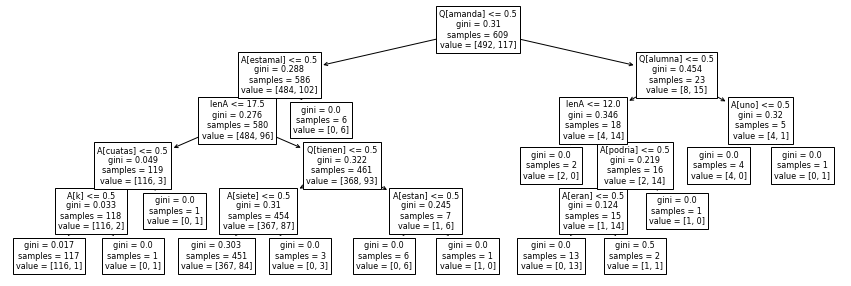

In [780]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
plot_tree(clf, feature_names=feature_names, ax=ax);

In [781]:
y_pred = clf.predict(X_bow)

In [782]:
X_bow[:, -1].shape

(677,)

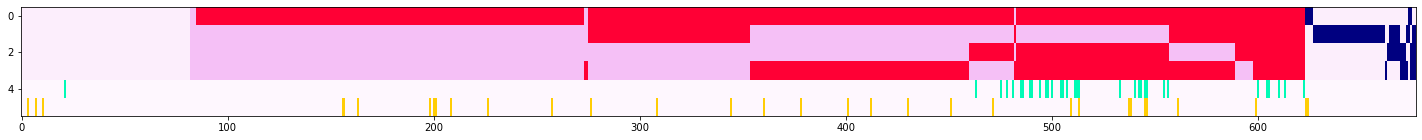

In [795]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(np.vstack([df_comp[[0, 1, 2, 3]].T.values, 75*y_pred, 40*(X_bow[:, -2])]), interpolation='nearest', aspect='auto', cmap="gist_ncar_r")

In [990]:
preds['gpt_label_v7.xlsx'].loc[df_comp.index]["gpt-label label Q A".split()].values[200]

array([0, 0,
       'Agustín desea guardar unos dados de 1 cm cúbico en una caja que mide 5 cm de largo, 2 cm de ancho y 2 cm de alto. Su hermano dice que caben en la caja 15 dados.¿Es correcto lo que señala el hermano de Agustín? Explica con tus palabras.',
       'esta mal  por caben 20 dados'], dtype=object)

In [770]:
q0 = [
    'El agricultor Braulio distribuye su cosecha de 35 choclos en 7 camionetas. Un trabajador dijo que en cada camioneta pondrán 4 choclos. ¿Está en lo correcto el trabajador? Explica con tus palabras.',
    'Agustín desea guardar unos dados de 1 cm cúbico en una caja que mide 5 cm de largo, 2 cm de ancho y 2 cm de alto. Su hermano dice que caben en la caja 15 dados.¿Es correcto lo que señala el hermano de Agustín? Explica con tus palabras.' ,  
]
q1 = [
    'Amalia compró 1,75 cm de elástico y Antonieta 1,57 cm. Una amiga de ellas les dijo que en total compraron 3 metros de elástico. ¿ Es correcto lo que les dice su amiga? Explica con tus palabras.',
    'Pedro y Alberto coleccionan estampillas de distintos países. Pedro tiene 63 y Alberto tiene 14 más que Pedro. Una amiga de ellos les dice que Alberto tiene en total 75 estampillas.¿Qué opinas tú respecto de lo que dice su amiga? ¿Está correcto? Explica con tus palabras.',
    'Doña Juanita tiene 3 maceteros y en cada uno plantó 8 flores.Su marido le dijo:" Juana, en total plantaste 25 flores". ¿Qué opinas tú respecto a lo que le dijo su marido? Explica con tus palabras.',
]
q0 = [unidecode(str(x)).lower().strip() for x in q0]
q1 = [unidecode(str(x)).lower().strip() for x in q1]
ex0 = X_data["Q"].apply(lambda x: str(x).lower().strip()).isin(q0).apply(int)
ex1 = X_data["Q"].apply(lambda x: str(x).lower().strip()).isin(q1).apply(int)

In [771]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

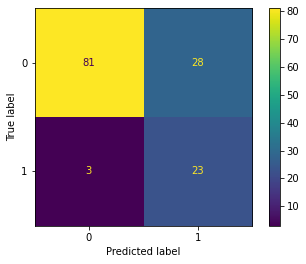

In [425]:
predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

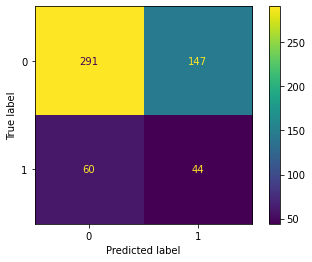

In [426]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [316]:
X_2 = seg.copy()
X_2["correcto"] = X_2.apply(lambda x: int("correcto" in x["Q"]), axis=1)
X_2 = X_2["lev correcto".split()]
X_2

,lev,correcto
id,,
85815,0.023256,0
64812,0.047059,0
84148,0.000000,0
88565,0.269231,0
51688,0.117647,0
...,...,...
54685,0.150000,1
87324,0.087719,1
73798,0.400000,0


In [317]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_data, stratify=y_data, test_size=.20, random_state=42)

In [323]:
clf = DecisionTreeClassifier(max_depth=3, class_weight="balanced")
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.4029574861367837, 0.36764705882352944)

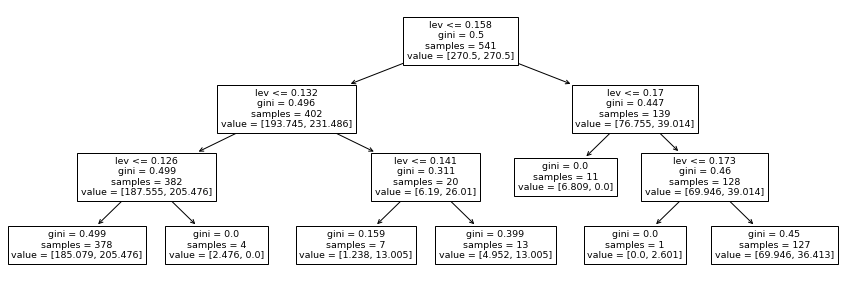

In [324]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
plot_tree(clf, feature_names=X_2.columns, ax=ax);

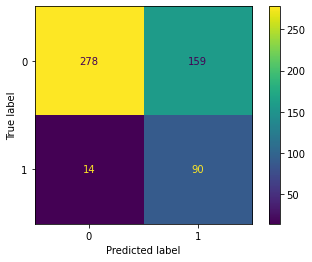

In [311]:
predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

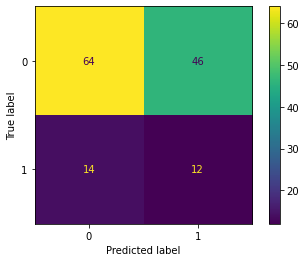

In [312]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.10, random_state=2022)

In [829]:
clf = Pipeline(steps=[
    ('vect', CountVectorizer(min_df=5, lowercase=True, ngram_range=(1, 3), stop_words=my_stop_words, tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha=1)),
])

In [830]:
clf.fit(X_train["Q"], y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words=['der', 'lar', 'car', 'el', 'er',
                                             'y', 'ar', 'los', 'del', 'ser',
                                             'lar', 'por', 'un', 'parar', 'con',
                                             'nar', 'unir', 'su', 'al', 'lar',
                                             'comer', 'más', 'perar', 'sus',
                                             'ler', 'ir', 'ar', 'er', 'ser',
                                             'porcar', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000001D422B38DF0>)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=1))])

In [748]:
from sklearn.model_selection import GridSearchCV

In [831]:
y_pred = clf.predict(X_train["Q"])
report = classification_report(y_train, y_pred, output_dict=True)
train_report = pd.DataFrame(report)
train_report

,0,1,accuracy,macro avg,weighted avg
precision,0.838998,0.540000,0.81445,0.689499,0.781555
recall,0.953252,0.230769,0.81445,0.592011,0.814450
f1-score,0.892483,0.323353,0.81445,0.607918,0.783143
support,492.000000,117.000000,0.81445,609.000000,609.000000


In [832]:
y_pred = clf.predict(X_test["Q"])
report = classification_report(y_test, y_pred, output_dict=True)
val_report = pd.DataFrame(report)
val_report

,0,1,accuracy,macro avg,weighted avg
precision,0.843750,0.750000,0.838235,0.796875,0.825827
recall,0.981818,0.230769,0.838235,0.606294,0.838235
f1-score,0.907563,0.352941,0.838235,0.630252,0.801532
support,55.000000,13.000000,0.838235,68.000000,68.000000


In [833]:
for x in np.argsort(clf["clf"].coef_[0])[-15:]:
    print(x, clf["vect"].get_feature_names()[x], clf["clf"].coef_[0][x]) 

1248 vierner -6.193426475305584
220 actividar -6.193426475305584
52 2 -6.176374499074753
478 cobrar -6.147925433323385
537 correctar decir -6.012202671492233
103 3 -5.850352580147477
438 chocolater -5.787000713363692
499 comprar -5.718871876575554
366 cadar -5.58645863087809
276 amigar -5.5473287838996335
744 explicar palabrar -5.426475014732937
532 correctar -5.310865093802841
991 palabrar -5.179584464016825
739 explicar -4.996905433591869
618 decir -4.8329090108338875


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [835]:
vector = clf["vect"].transform(X_data["Q"])

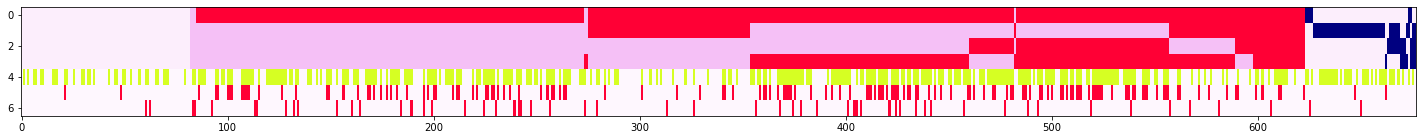

In [851]:
fig, ax = plt.subplots(1, 1, figsize=(25, 2))
ax.imshow(np.vstack([df_comp[[0, 1, 2, 3]].T.values, 50*np.array(vector[:, 739].todense()>0).ravel(), 25*np.array([int("mal" in x.lower()) for x in X_raw["A"]]), 25*np.array([int("bien" in x.lower()) for x in X_raw["A"]])]), interpolation='nearest', aspect='auto', cmap="gist_ncar_r")

In [473]:
from sklearn.metrics import classification_report

3 [('correcto', 0.3591136496169584), ('palabras', 1.7333457340390808), ('amiga', 0.5582847084162663)]
1 [('para', -0.39021787803926905)]


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Wall time: 346 ms


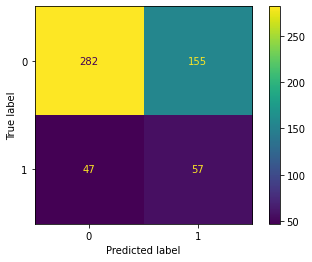

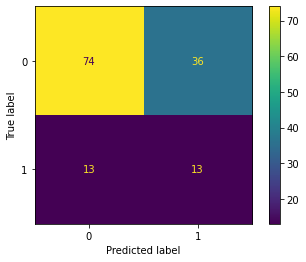

In [490]:
%%time
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(use_idf=False)),
    ("clf", LogisticRegression(
        C=0.4,
        penalty="l1", 
        class_weight="balanced", 
        solver="liblinear", 
        random_state=42))
])
pipe.fit(X_train["Q"], y_train)
ixs = np.where(pipe["clf"].coef_>0)[1]
cols = [(k, pipe["clf"].coef_[0, v]) for k, v in pipe["tfidf"].vocabulary_.items() if v in ixs]
print(len(cols), cols)
ixs = np.where(pipe["clf"].coef_<0)[1]
cols = [(k, pipe["clf"].coef_[0, v]) for k, v in pipe["tfidf"].vocabulary_.items() if v in ixs]
print(len(cols), cols)
plot_confusion_matrix(pipe, X_train["Q"], y_train);
plot_confusion_matrix(pipe, X_test["Q"], y_test);